In [9]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd
import scipy.stats as sc
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [38]:
import glob


# pattern per prendere TUTTI i file astri_???_43_009_00002_R_*_SEB.lv0
file_list = sorted(glob.glob("astri_???_43_009_00002_R_20102*_0201_SEB.lv0"))

dfs = []
print("\n")

for filename in file_list:
    print(filename)

    with at.io.fits.AstriFits(filename) as hdul:
        if len(hdul.hdul) <= 1:
            print(f"⚠️  File senza estensione [1], salto: {filename}")
            continue
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns

        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])

        # Estraggo TEL_ID da filename (es: astri_003_... → 003)
        tel_id = int(filename.split("_")[1])

        df = pd.DataFrame({
            "TIME_NS": time_ns,
            "TIME_S": time_s,
            "TIME_ABS": time_abs,
            "EVENT": event,
            "MCRUN": mcrun,
            "TEL_ID": tel_id,
            "HG": list(hg),
            "LG": list(lg),
            "TTP": list(ttp),
        })

        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted = df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
df_all_sorted["shape"] = df_all_sorted["HG"].apply(np.sum).to_numpy()

print(df_all.head())
print(df_all_sorted.head())




astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201024_008_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201021_002_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201020_006_0201_SEB.lv0
astri_008_43_009_00002_R_201022_007_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201024_008_0201_SEB.lv0
astri_009_43_009_00002_R_201021_002_0201_SEB.lv0
astri_009_43_009_00002_R_201022_007_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201024_008_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1 

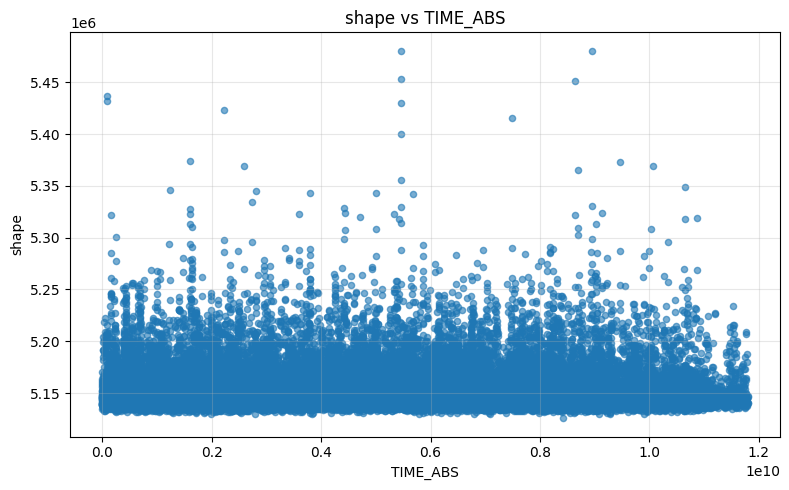

In [39]:
plt.figure(figsize=(8, 5))

plt.scatter(df_all_sorted["TIME_ABS"],df_all_sorted["shape"],s=20,alpha=0.6)
plt.xlabel("TIME_ABS")
plt.ylabel("shape")
plt.title("shape vs TIME_ABS")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/home/matfra/miniconda3/envs/astrienv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Eventi selezionati: 1


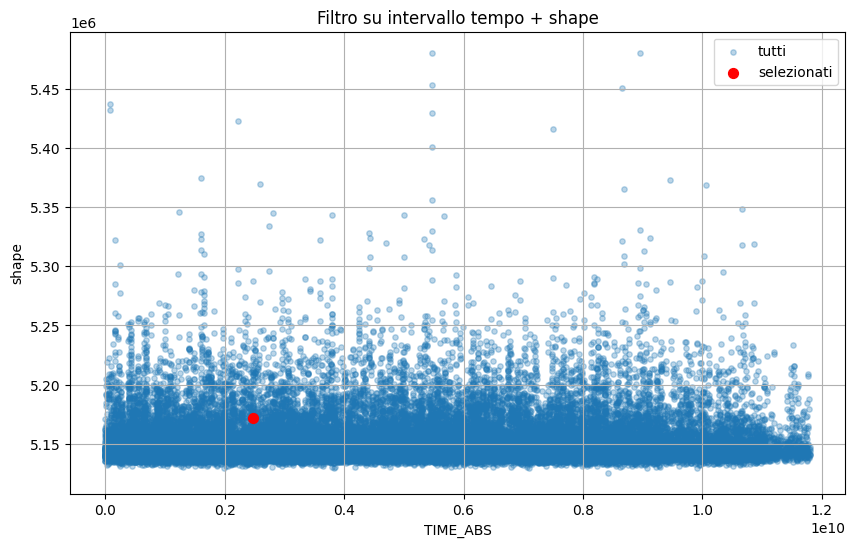

         TIME_NS  TIME_S    TIME_ABS  EVENT   MCRUN  TEL_ID  \
13057  473242821       2  2473242821   7009  263458       1   

                                                      HG  \
13057  [[2168, 2214, 2208, 2267, 2125, 2084, 2213, 22...   

                                                      LG  \
13057  [[2130, 2132, 2132, 2135, 2128, 2126, 2132, 21...   

                                                     TTP    shape     logdt  \
13057  [[255, 255, 255, 255, 255, 159, 255, 255, 255,...  5171795  1.623249   

       MCRUN_prev  EVENT_prev  shape_prev  
13057    263458.0      7008.0   5184472.0  


In [40]:

# ======= SOGLIE ======    
shape_cut = 5.17e6   

# ================================================
df_all_sorted["logdt"] = np.log10(df_all_sorted["TIME_ABS"].diff().abs())
df_all_sorted["MCRUN_prev"] = df_all_sorted["MCRUN"].shift(1)
df_all_sorted["EVENT_prev"] = df_all_sorted["EVENT"].shift(1)
df_all_sorted["shape_prev"] = df_all_sorted["shape"].shift(1)

df_sel = df_all_sorted[ (df_all_sorted["logdt"] < 3) & (df_all_sorted["shape"] >= shape_cut)
                        & (df_all_sorted["EVENT"] != df_all_sorted["EVENT_prev"]) &
                        (df_all_sorted["shape_prev"] >= shape_cut)]

print("Eventi selezionati:", len(df_sel))

# ======= PLOT DEI PUNTI SELEZIONATI =======

plt.figure(figsize=(10,6))
plt.scatter(df_all_sorted["TIME_ABS"], df_all_sorted["shape"], 
            s=15, alpha=0.3, label="tutti")

plt.scatter(df_sel["TIME_ABS"], df_sel["shape"], 
            s=50, color="red", label="selezionati")

plt.xlabel("TIME_ABS")
plt.ylabel("shape")
plt.title("Filtro su intervallo tempo + shape")
plt.legend()
plt.grid(True)
plt.show()
df_sel=df_sel.sort_values(by="TIME_ABS")
print(df_sel)

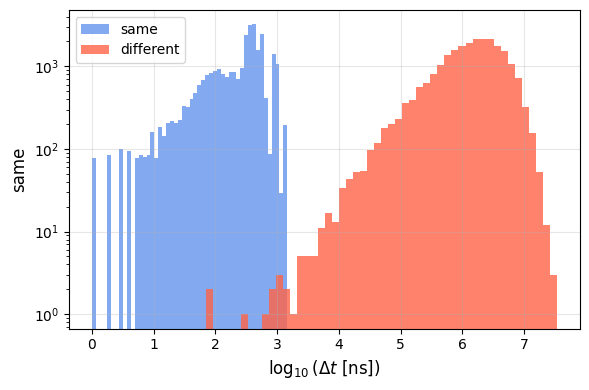

In [41]:
#altro approccio-----------------------
delta_t=np.diff(df_all_sorted["TIME_ABS"])
delta_ts = delta_t[delta_t > 0] #uso maschere e cambio

#ordino eventi con il for e suddivisione same e different
df_all_sorted=df_all_sorted.sort_values(["MCRUN","EVENT","TIME_ABS"]).reset_index(drop=True)
delta_t_same = []
delta_t_diff = []

for i in range(1, len(df_all_sorted)):
    if ((df_all_sorted.loc[i, "MCRUN"]==df_all_sorted.loc[i-1, "MCRUN"])&
        (df_all_sorted.loc[i, "EVENT"] ==df_all_sorted.loc[i-1, "EVENT"])):
        delta_t_same.append(df_all_sorted.loc[i, "TIME_ABS"]-
                            df_all_sorted.loc[i-1, "TIME_ABS"])
    else:
        delta_t_diff.append(df_all_sorted.loc[i, "TIME_ABS"]-
                            df_all_sorted.loc[i-1, "TIME_ABS"])
delta_t_same = np.array(delta_t_same)
delta_t_diff = np.array(delta_t_diff)
delta_t_same_safe = np.where(delta_t_same > 0, delta_t_same, 1)
delta_t_diff_safe = np.where(delta_t_diff > 0, delta_t_diff, 1)
#suddivido tra stesso evento e evento separato sostituendo i deltat con 1
plt.figure(figsize=(6, 4))
plt.hist(np.log10(delta_t_same[delta_t_same > 0]), bins=50, color='cornflowerblue',
         alpha=0.8,label='same')
plt.hist(np.log10(delta_t_diff[delta_t_diff > 0]), bins=50, color='tomato',
         alpha=0.8,label='different')
plt.yscale('log')
plt.xlabel(r'$\log_{10}(\Delta t\ \mathrm{[ns]})$', fontsize=12)
plt.ylabel('same', fontsize=12)
#plt.xlim(left=0)
plt.tight_layout()
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# Calcolo Δt = TIME_ABS(i) - TIME_ABS(i-1)
df_all_sorted["delta_t"] = df_all_sorted["TIME_ABS"].diff()

# ============================================================
# CLASSIFICAZIONE: same o different 

# true se MCRUN(i) = MCRUN(i-1) E EVENT(i) = EVENT(i-1)
same = (
    (df_all_sorted["MCRUN"] == df_all_sorted["MCRUN"].shift(1)) &
    (df_all_sorted["EVENT"] == df_all_sorted["EVENT"].shift(1))
)

# Creo una colonna che dice se un Δt appartiene allo stesso evento oppure no
df_all_sorted["class"] = np.where(same, "same", "different")

# ============================================================


peaks_red = df_all_sorted[
    (df_all_sorted["class"] == "different") &      # solo eventi "rossi"
    (df_all_sorted["delta_t"] > 0) &               # niente valori negativi
    (np.log10(df_all_sorted["delta_t"]) < 3)       # Δt < 10^3 ns
]

print(peaks_red[["EVENT", "MCRUN", "delta_t", "shape"]].head())


       EVENT   MCRUN  delta_t    shape
8291    8715  262914    973.0  5140138
16405   9708  263426    749.0  5143514
18391   3304  263496    857.0  5143733
19528   7400  263632    293.0  5142691
21248   7500  263696    629.0  5192301


/home/matfra/miniconda3/envs/astrienv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matfra/miniconda3/envs/astrienv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
# CERCO LA RIGA DOVE EVENT = 
idx = df_all_sorted.index[(df_all_sorted["EVENT"] == 7500)&(df_all_sorted["MCRUN"]==263696 )]

if len(idx) > 0:
    i = idx[0]   # primo match

    # MOSTRARE 5 RIGHE PRIMA E 5 DOPO
    print(df_all_sorted[['TIME_ABS','EVENT','MCRUN','shape','delta_t']].iloc[max(0, i-5): i+6])
else:
    print("EVENT non trovato!")


         TIME_ABS  EVENT   MCRUN    shape    delta_t
21243  3973301659   3519  263696  5141951  1219615.0
21244  3974111523   4116  263696  5141118   809864.0
21245  3974587493   4316  263696  5139680   475970.0
21246  3976367345   6414  263696  5137670  1779852.0
21247  3976367880   6414  263696  5141059      535.0
21248  3976368509   7500  263696  5192301      629.0
21249  3976368680   7500  263696  5180574      171.0
21250  3976368821   7500  263696  5171868      141.0
21251  3976368910   7500  263696  5185440       89.0
21252  3976369232   7500  263696  5165416      322.0
21253  3976369284   7500  263696  5176604       52.0
